# Data Preparation: Murdock & Okada (1970)

> Murdock, B. B., & Okada, R. (1970). Interresponse times in single-trial free recall. Journal of Experimental Psychology, 86(2), 263.  

Authors investigated interresponse times in single-trial free recall. Each of 72 undergraduates was given 20 test lists with 20-word lists visually presented at either 60 or 120 words/min. The format of the data in these files is as follows:  

Row 1: subject/trial information. Trial index, subject index, subject-trial index. I'm not seeing presentation speed.  
Row 2: serial position as a function of output position.  
Row 3: inter-response time as a function of output position  

The code 88 means that the subject made an extra-list intrusion.

## Old Version: For Psifr Format

In [1]:
import numpy as np
import pandas as pd
from psifr import fr

def prepare_murdock1970_data(path):
    """
    Prepares data formatted like `data/MurdData_clean.mat` for fitting.

    Loads data from `path` with same format as `data/MurdData_clean.mat` and 
    returns a selected dataset as an array of unique recall trials and a 
    dataframe of unique study and recall events organized according to `psifr`
    specifications.  

    **Arguments**:  
    - path: source of data file  
    - dataset_index: index of the dataset to be extracted from the file

    **Returns**:
    - trials: int64-array where rows identify a unique trial of responses and 
        columns corresponds to a unique recall index.  
    - merged: as a long format table where each row describes one study or 
        recall event.  
    - list_length: length of lists studied in the considered dataset
    """
    
    with open(path) as f:
        oka_data = f.read()

    counter = 0
    trials = []
    subjects = []
    list_length = 20

    for line in oka_data.split('\n'):

        if not line:
            continue

        # build subjects array
        if counter == 0:
            subjects.append(int(line.strip().split('    ')[1]))

        # build trials array
        if counter == 1:

            trial = [int(each) for each in line.strip().split('    ')]
            trial = [each for each in trial if each <= 20]
            already = []
            for each in trial:
                if each not in already:
                    already.append(each)
            trial = already
            
            while len(trial) < 13:
                trial.append(0)

            trials.append(trial)

        # keep track of which row we are on for the given trial
        counter += 1
        if counter == 3:
            counter = 0

    trials = np.array(trials).astype('int64')
    
    data = []
    for trial_index, trial in enumerate(trials):

        # every time the subject changes, reset list_index
        if not data or data[-1][0] != subjects[trial_index]:
            list_index = 0
        list_index += 1

        # add study events
        for i in range(list_length):
            data += [[subjects[trial_index], 
                      list_index, 'study', i+1, i]]

        # add recall events
        for recall_index, recall_event in enumerate(trial):
            if recall_event != 0:
                data += [[subjects[trial_index], list_index, 
                          'recall', recall_index+1, recall_event-1]]

    data = pd.DataFrame(data, columns=[
        'subject', 'list', 'trial_type', 'position', 'item'])
    merged = fr.merge_free_recall(data)
    return trials, merged, list_length

In [2]:
trials, events, length = prepare_murdock1970_data('data/raw/mo1970.txt')
events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,prior_list,prior_input
0,1,1,0,1,NaN,True,False,0,False,NaN,NaN
1,1,1,1,2,NaN,True,False,0,False,NaN,NaN
2,1,1,2,3,NaN,True,False,0,False,NaN,NaN
3,1,1,3,4,NaN,True,False,0,False,NaN,NaN
4,1,1,4,5,NaN,True,False,0,False,NaN,NaN


## EMBAM Format

In [3]:
import numpy as np
from typing import Dict
from numpy.typing import ArrayLike
from jaxcmr.helpers import save_dict_to_hdf5


def prepare_recall_dataset_with_irt(path: str) -> Dict[str, ArrayLike]:
    """
    Converts raw recall data into the RecallDataset format including inter-response times (irt).

    Args:
        path: Path to the data file.

    Returns:
        A dictionary adhering to the RecallDataset format with `irt` included.
    """

    with open(path, 'r') as f:
        raw_data = f.read().splitlines()

    list_length = 20
    subject_ids, pres_itemnos, recalls, irts = [], [], [], []
    trial_counter = 0

    for idx in range(0, len(raw_data), 3):
        if idx + 2 >= len(raw_data):
            continue  # Skip incomplete trials

        # Parse subject ID
        subject_line = raw_data[idx].strip().split()
        subject_id = int(subject_line[1])
        subject_ids.append(subject_id)

        # Parse recall events
        recall_line = raw_data[idx + 1].strip().split()
        trial_recalls = [int(num) for num in recall_line if num.isdigit() and int(num) <= list_length]

        # Ensure uniqueness of recalls
        seen = set()
        unique_recalls = []
        for num in trial_recalls:
            if num not in seen:
                seen.add(num)
                unique_recalls.append(num)

        num_recalled = len(unique_recalls)

        # Padding recalls with zeros
        padded_recalls = unique_recalls + [0] * (list_length - num_recalled)
        recalls.append(padded_recalls)

        # Parse inter-response times (IRT)
        irt_line = raw_data[idx + 2].strip().split()
        trial_irts = []
        irt_counter = 0
        for recall_num in trial_recalls:
            if recall_num in seen:
                trial_irts.append(int(float(irt_line[irt_counter]) * 1000))  # Convert to milliseconds)
                irt_counter += 1
                seen.remove(recall_num)  # To match IRT with unique recall

        # Padding irt with zeros
        padded_irts = trial_irts + [0] * (list_length - len(trial_irts))
        irts.append(padded_irts)

        # Presentation items: fixed 1...list_length
        pres_itemnos.append(list(range(1, list_length + 1)))

        trial_counter += 1

    dataset = {
        'subject': np.array(subject_ids, dtype=int).reshape(-1, 1),
        'listLength': np.full((trial_counter, 1), list_length, dtype=int),
        'pres_itemnos': np.array(pres_itemnos, dtype=int),
        'recalls': np.array(recalls, dtype=int),
        'irt': np.array(irts, dtype=int)
    }

    return dataset

# Example usage:
dataset = prepare_recall_dataset_with_irt('data/raw/mo1970.txt')

# Inspect dataset structure
for key, value in dataset.items():
    print(f"{key}: shape {value.shape}\n{value[:2]}\n")
save_dict_to_hdf5(dataset, "data/MurdockOkada1970.h5")

subject: shape (1440, 1)
[[1]
 [1]]

listLength: shape (1440, 1)
[[20]
 [20]]

pres_itemnos: shape (1440, 20)
[[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]]

recalls: shape (1440, 20)
[[15 16 17 18 20 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [11 15 16 18 19  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0]]

irt: shape (1440, 20)
[[1500  960  970 1200 1400 4300    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [2300 1300 1200 1700 3100 3500 2000    0    0    0    0    0    0    0
     0    0    0    0    0    0]]



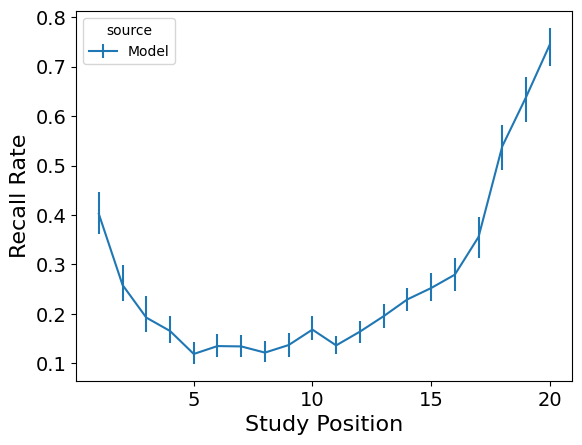

/Users/jordangunn/jaxcmr/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


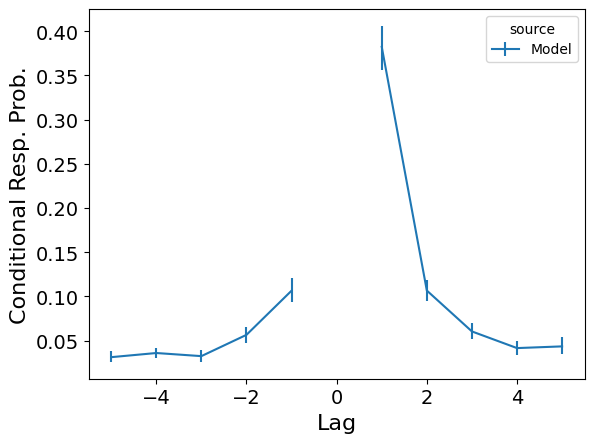

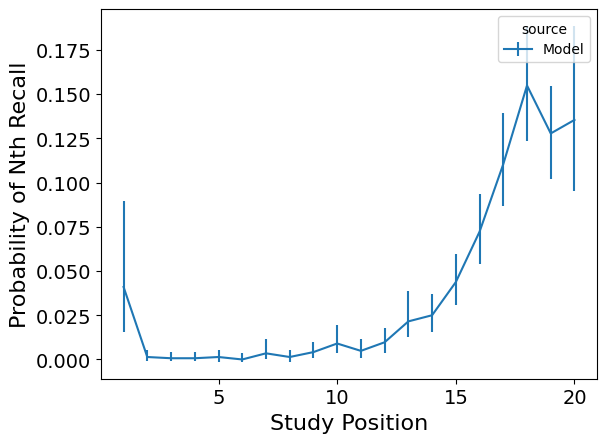

In [ ]:
from jaxcmr.helpers import import_from_string, generate_trial_mask
from matplotlib import rcParams  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
from jaxcmr.experimental.array import to_numba_typed_dict
import jax.numpy as jnp

comparison_analysis_paths = [
    "jaxcmr.spc.plot_spc",
    "jaxcmr.crp.plot_crp",
    "jaxcmr.pnr.plot_pnr",
    # "compmempy.analyses.distance_crp.plot_distance_crp",
]
comparison_analyses = [import_from_string(path) for path in comparison_analysis_paths]
max_size = np.max(dataset["pres_itemnos"])
connections = jnp.zeros((max_size, max_size))
trial_mask = jnp.ones(len(dataset["recalls"]), dtype=bool)

for analysis in comparison_analyses:
    color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

    axis = analysis(
        datasets=[
            to_numba_typed_dict({key: np.array(value) for key, value in dataset.items()}),
        ],
        trial_masks=[np.array(trial_mask)],
        color_cycle=color_cycle,
        labels=["Model", "Data"],
        contrast_name="source",
        axis=None,
        distances=1 - connections,
    )

    axis.tick_params(labelsize=14)
    axis.set_xlabel(axis.get_xlabel(), fontsize=16)
    axis.set_ylabel(axis.get_ylabel(), fontsize=16)
    # axis.set_title(f'{results["name"]}'.replace("_", " "))
    plt.show()